<a href="https://colab.research.google.com/github/rosieiiiii/KR_return_example/blob/main/KR_return_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we provide an example of using the kernel ridge (KR) model for zero-coupon bond returns estimation using U.S. Treasury data. This notebook runs on Google Colab.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps 
import time
import sys
import os
import pickle

## download KR example files from Github
# if not os.path.exists('KR_return_example'):
#     !git clone https://github.com/rosieiiiii/KR_return_example.git
dir_kr = '/content/KR_return_example/'

sys.path.append(dir_kr+'source/')
from source import models
from source import kernel


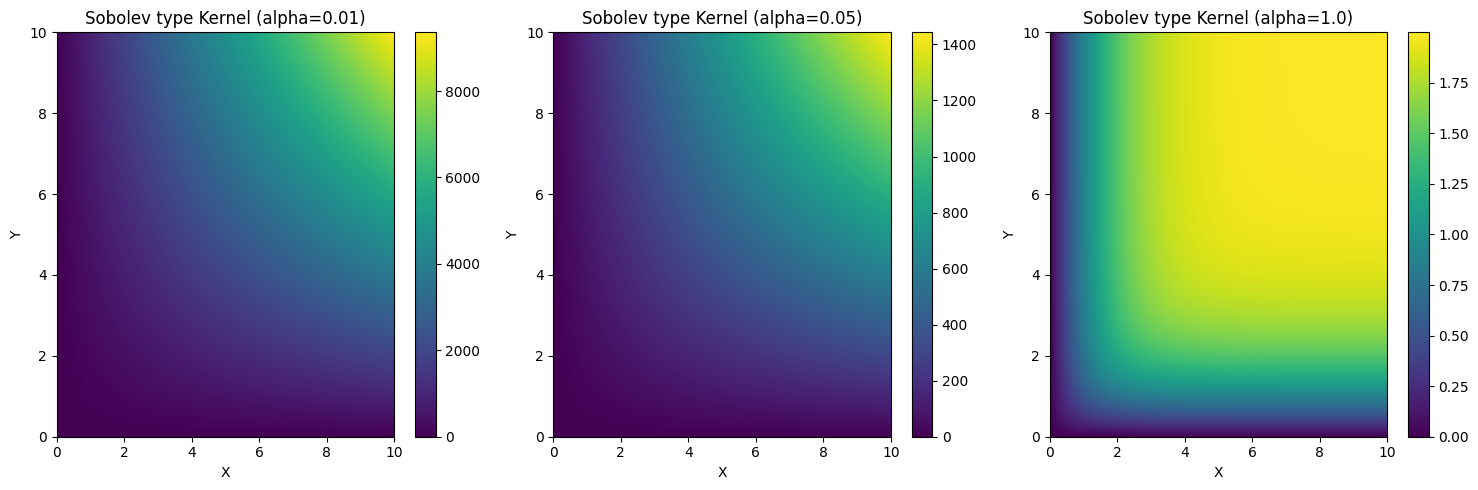

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian_kernel(x, y, sigma):
    return np.exp(-(x-y)**2 / (2 * sigma**2))

def sobolev_kernel_delta0(x,y,alpha):
    min_xy=np.minimum(x,y)
    max_xy=np.maximum(x,y)
    return -min_xy/alpha**2*np.exp(-alpha*min_xy)+\
                2/alpha**3*(1-np.exp(-alpha*min_xy))-\
                min_xy/alpha**2*np.exp(-alpha*max_xy)

# Define grid
x = np.linspace(0, 10, 365)
y = np.linspace(0, 10, 365)
X, Y = np.meshgrid(x, y)

# Define sigma values
alphas = [0.01, 0.05, 1.0]

# Plot Gaussian kernels
fig = plt.figure(figsize=(15, 5))
# for i, alpha in enumerate(alphas, start=1):
#     Z = sobolev_kernel_delta0(X, Y, alpha)
#     ax = fig.add_subplot(1, 3, i, projection='3d')
#     ax.plot_surface(X, Y, Z, cmap='viridis')
#     ax.set_title(f'Sobolev type Kernel (alpha={alpha})')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Kernel Value')

for i, alpha in enumerate(alphas, start=1):
    Z = sobolev_kernel_delta0(X, Y, alpha)
    ax = fig.add_subplot(1, 3, i)
    c = ax.imshow(Z, extent=(0, 10, 0, 10), origin='lower', cmap='viridis', aspect='auto')
    ax.set_title(f'Sobolev type Kernel (alpha={alpha})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()



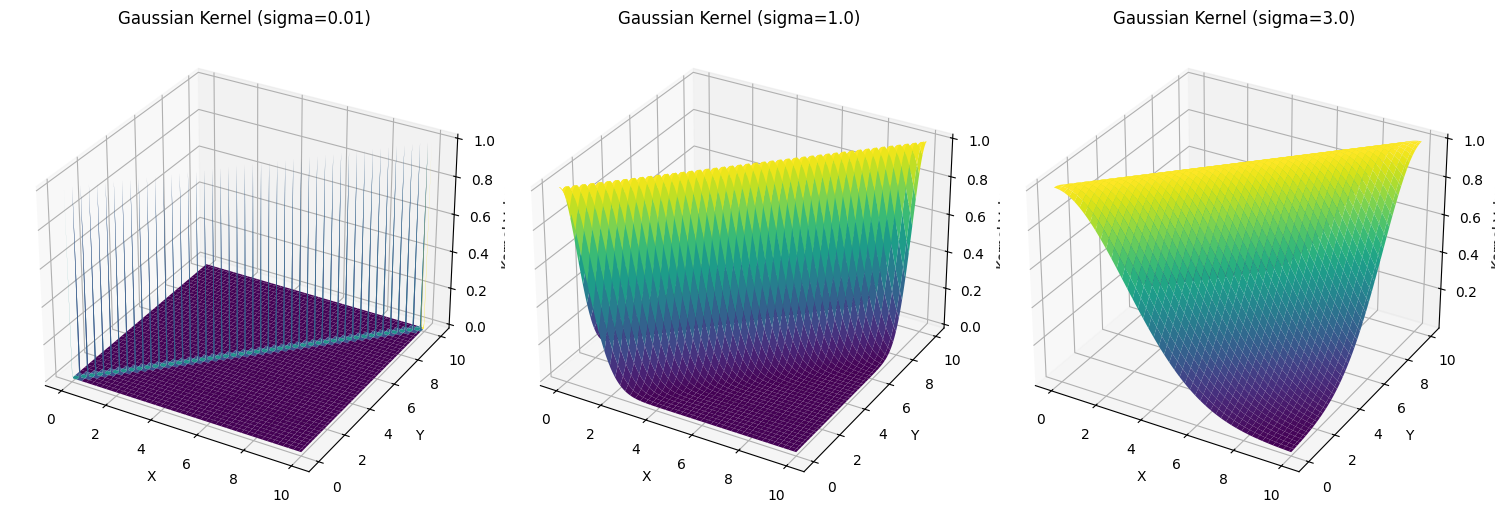

In [49]:
x = np.linspace(0, 10, 365)
y = np.linspace(0, 10, 365)
X, Y = np.meshgrid(x, y)

# Define sigma values
sigmas = [0.01, 1.0, 3.0]

# Plot Gaussian kernels
fig = plt.figure(figsize=(15, 5))
for i, sigma in enumerate(sigmas, start=1):
    Z = gaussian_kernel(X, Y, sigma)
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(f'Gaussian Kernel (sigma={sigma})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Kernel Value')

# for i, sigma in enumerate(sigmas, start=1):
#     Z = gaussian_kernel(X, Y, sigma)
#     ax = fig.add_subplot(1, 3, i)
#     c = ax.imshow(Z, extent=(0, 10, 0, 10), origin='lower', cmap='viridis', aspect='auto')
#     ax.set_title(f'Gaussian Kernel (sigma={sigma})')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Generating kernel matrix
KR has three hyper-parameters: $\alpha$, $\delta$, and $\lambda$, among which $\alpha$ and $\delta$ are shape hyper-parameters that determine the kernel matrix. For a fixed pair of $\alpha$ and $\delta$, we need to generate a kernel matrix only once, which can be shared across multiple cross-sections. $\lambda$ controls the degree of smoothness and model complexity. Baseline values for these three hyper-parameters are $\alpha=0.05$, $\delta=0$, and $\lambda=1$.

In this example, we generate a kernel matrix of dimension $N$-by-$N$, where $N$ is the maximum time-to-maturity of the discount curve that we are about to estimate. $N$ needs to be no less than the maximum time-to-maturity in days $N'$ of securities in the data so that pricing error can be calculated. When $N>N'$, we also obtain extrapolated curve estimates.

In [9]:
### settings
# kernel hyper-parameters
alpha = 0.05
delta = 0.00

# max time to maturity in days
N = 10*365

start_time = time.time()
K = kernel.generate_kernel_matrix(alpha, delta, N, N)
end_time = time.time()

print('Time elapsed for generating a {}-by-{} kernel matrix with alpha = {} and delta = {}: {:.1f} sec'\
      .format(N,N,alpha, delta, end_time-start_time))

# SVD
U,D_diag,Vh = np.linalg.svd(K)
V = Vh.T
D = np.diag(D_diag) # D is a matrix
DV_inv = V@np.diag(1/np.sqrt(D_diag))
assert np.isclose(U[:,:10],V[:,:10]).all()

dict_svd = {'V':V,
            'D_diag':D_diag,
            'DV_inv':DV_inv}

Time elapsed for generating a 3650-by-3650 kernel matrix with alpha = 0.05 and delta = 0.0: 0.7 sec


In [15]:
import numpy as np

# Example 3 by 5 matrix Z
Z = np.array([[1, 0, 3, 0, 5],
              [0, 2, 0, 0, 0],
              [6, 0, 8, 0, 0]])
K = np.random.rand(5, 5)
K = (K + K.T) / 2
K = K + 5 * np.eye(5)
arr_msk_col = np.where(Z.sum(axis=0) != 0)[0]
# Applying np.where() to find indices where sum of each column is not zero
l=10
tau_max_inday=arr_msk_col[-1]+1
l_scaled=l/tau_max_inday

Z_masked=Z[:,arr_msk_col]
K_masked=K.take(arr_msk_col,axis=0).take(arr_msk_col,axis=1)
A=K@Z.T@np.linalg.inv(Z@K@Z.T+l_scaled*np.eye(3))
B=K.take(arr_msk_col,axis=1)@Z_masked.T@np.linalg.inv(Z_masked@K_masked@Z_masked.T + l_scaled * np.eye(3))
print("Indices of columns where sum is not zero:", arr_msk_col)
print(np.where(Z.sum(axis=0) != 0))
print(tau_max_inday)
print(A)
print(B)


Indices of columns where sum is not zero: [0 1 2 4]
(array([0, 1, 2, 4], dtype=int64),)
5
[[-2.47949931e-02  3.72841339e-02  7.28995175e-02]
 [ 1.37963630e-03  4.56610716e-01  3.82700300e-04]
 [ 1.93379512e-02 -2.78674254e-02  6.96443537e-02]
 [-1.30370447e-03  1.22181119e-03  1.42838408e-02]
 [ 1.90153836e-01  9.81548296e-03 -5.51797854e-02]]
[[-2.47949931e-02  3.72841339e-02  7.28995175e-02]
 [ 1.37963630e-03  4.56610716e-01  3.82700300e-04]
 [ 1.93379512e-02 -2.78674254e-02  6.96443537e-02]
 [-1.30370447e-03  1.22181119e-03  1.42838408e-02]
 [ 1.90153836e-01  9.81548296e-03 -5.51797854e-02]]


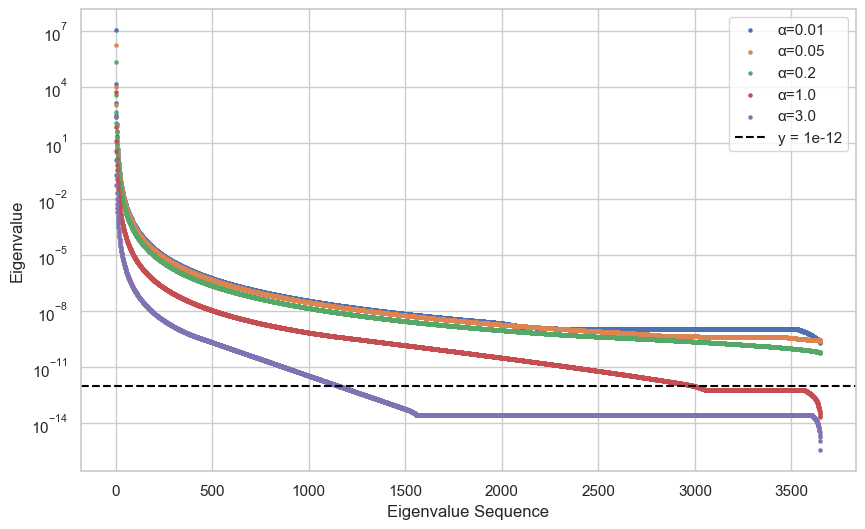

[3650, 3650, 3650, 2987, 1149]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Example matrix (you can replace this with your own matrix)
# alpha = 0.05
delta = 0.00

# max time to maturity in days
N = 10*365
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
er=[]
for alpha in [0.01,0.05,0.2,1.0,3.0]:
    K = kernel.generate_kernel_matrix(alpha, delta, N, N)
    U,D_diag,Vh = np.linalg.svd(K)
    indices = np.arange(1, len(D_diag) + 1)
    plt.scatter(indices, D_diag, s=5, label=f'\u03B1={alpha}')
    er.append(np.sum(D_diag > 1e-12))
plt.yscale('log')
# Add a horizontal line at y = 1e-12
plt.axhline(y=1e-12, color='black', linestyle='--', label='y = 1e-12')

# Add labels and legend
plt.xlabel('Eigenvalue Sequence')
plt.ylabel('Eigenvalue')
plt.legend()

save_path = os.path.join("D:\Document\EPFL_Coursework\MasterThesis\Plots", 'eig_sobolev.png')
plt.savefig(save_path)
# Show plot
plt.show()

print(er)


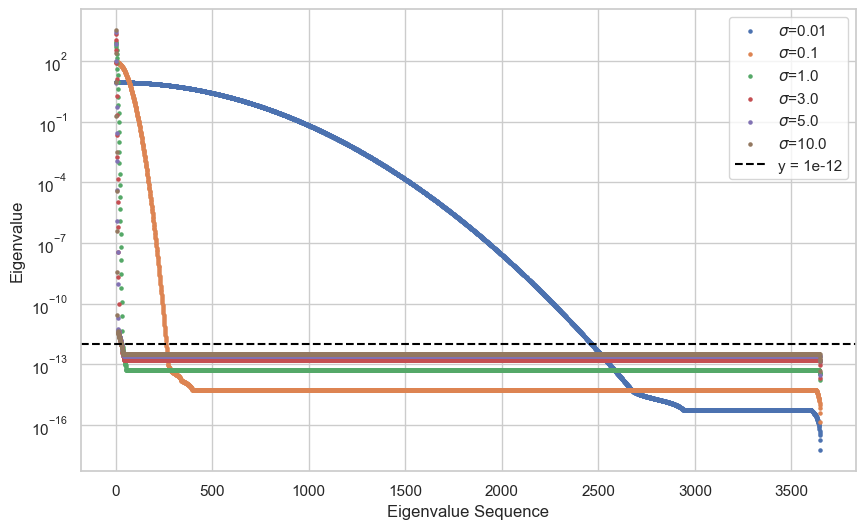

[2464, 262, 33, 27, 30, 27]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Example matrix (you can replace this with your own matrix)


# max time to maturity in days
N = 10*365
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
er=[]
for sigma in [0.01,0.1,1.0,3.0,5.0,10.0]:
    K = kernel.generate_kernel_matrix_Gauss(sigma, N, N)
    U,D_diag,Vh = np.linalg.svd(K)
    indices = np.arange(1, len(D_diag) + 1)
    plt.scatter(indices, D_diag, s=5, label=f'$\sigma$={sigma}')
    er.append(np.sum(D_diag > 1e-12))
plt.yscale('log')
# Add a horizontal line at y = 1e-12
plt.axhline(y=1e-12, color='black', linestyle='--', label='y = 1e-12')

# Add labels and legend
plt.xlabel('Eigenvalue Sequence')
plt.ylabel('Eigenvalue')
plt.legend()
save_path = os.path.join("D:\Document\EPFL_Coursework\MasterThesis\Plots", 'eig_Gaussian.png')
plt.savefig(save_path)
# Show plot
plt.show()
print(er)


# Gaussian Kernel

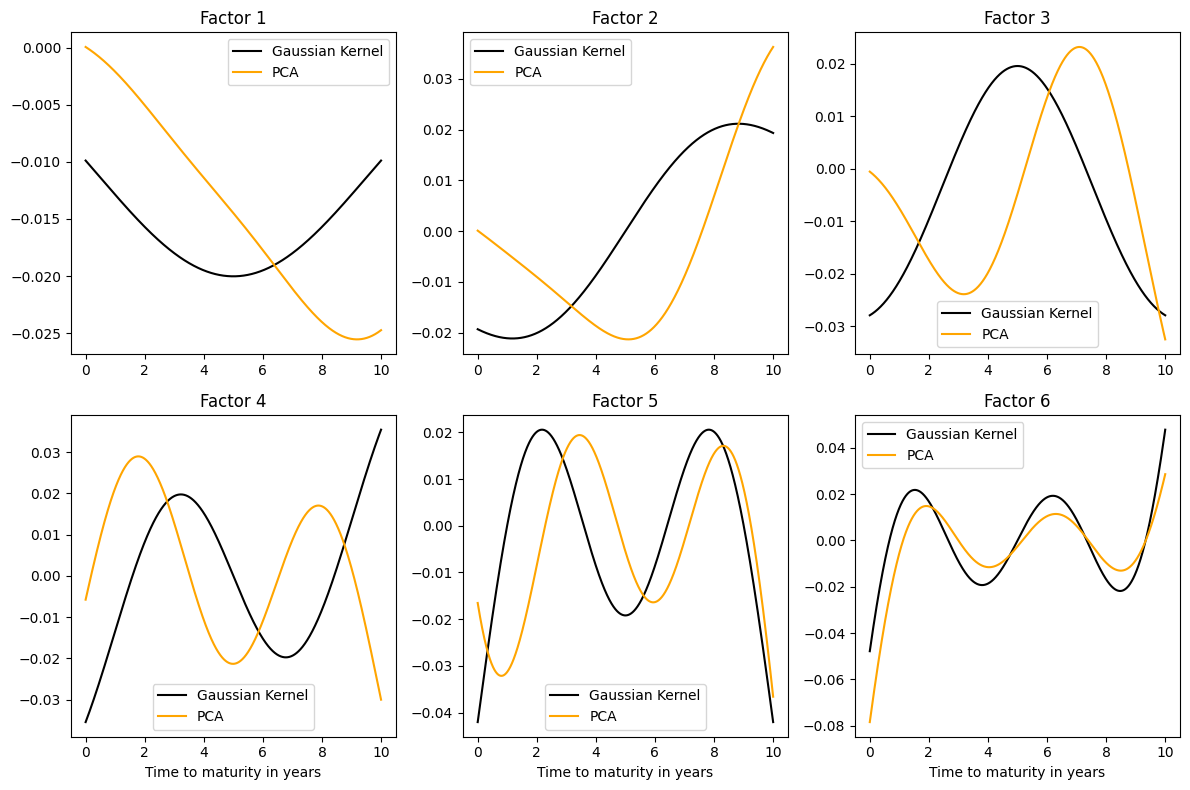

In [6]:
from sklearn.decomposition import PCA
import pandas as pd

N = 10*365
sigma=3.0
start_time = time.time()
K_Gauss = kernel.generate_kernel_matrix_Gauss(sigma, N, N)
end_time = time.time()
U,D_diag,Vh = np.linalg.svd(K_Gauss)
V = Vh.T
D = np.diag(D_diag) # D is a matrix

DV=V@np.diag(np.sqrt(D_diag))
DV_normalizied=DV/np.linalg.norm(DV, axis=0)

# Loadings of PCA
idx_ver=5
R=10
alpha=3.0
delta=0.0
l_fixed=1.0
rf_source='KR_LS'
dir_out='./KR_ret_models/summary_results/summary_ret_curve_R_{}_alpha_{}_ridge_{}_RF_{}_daily_ver_{}/'\
    .format(R, alpha, l_fixed, rf_source, idx_ver)

dict_zcb=pd.read_pickle(dir_out+'dict_zcb.pkl')
df_zcb_rx_daily=dict_zcb['df_zcb_rx_daily']

X=df_zcb_rx_daily
centered_X=X-X.mean(axis=0)
pca = PCA(n_components=6)
pca.fit(centered_X)
A=pca.components_.T
A_normalizied=A/np.linalg.norm(A, axis=0)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

days = np.arange(1, 3651)
years = days / 365 

for i in range(6):
    row = i//3
    col = i %3
    axs[row, col].plot(years, DV_normalizied[:,i], color='black', label='Gaussian Kernel')
    if i in [0,2,4]:
        axs[row, col].plot(years, -A_normalizied[:, i], color='orange', label='PCA')
    else:
        axs[row, col].plot(years, A_normalizied[:, i], color='orange', label='PCA')

    # axs[row, col].plot(years, -A_normalizied[:, i], color='orange', label='PCA')
    axs[row, col].set_title(f'Factor {i+1}')
    axs[row, col].legend()

for ax in axs[-1]:
    ax.set_xlabel('Time to maturity in years')

plt.tight_layout()
plt.show()

In [35]:
dir_base='.'
dir_B = dir_base+'/B_and_C/B_max_ttm_10yr/'
# df_t_lookup_freq=pd.read_pickle(dir_B+'df_t_lookup_{}.pkl'.format(args.freq))
df_t_lookup_daily=pd.read_pickle(dir_B+'df_t_lookup_{}.pkl'.format('daily'))
T=14866
df_t_lookup_daily.head()
date_index=df_t_lookup_daily.index[:T]

df_t_lookup_daily=df_t_lookup_daily.iloc[:14866]

df_t_lookup_daily

,t
1961-06-14,0
1961-06-15,1
1961-06-16,2
1961-06-19,3
1961-06-20,4
...,...
2020-12-24,14861
2020-12-28,14862
2020-12-29,14863
2020-12-30,14864


In [18]:
# Cross validation
import pandas as pd

def last_trading_day_index(x):
    return x.idxmax()

def one_fit(Z, # dim: (nt, Nmax-date_s)
            l_unscaled,
            rx, # (Bc_shift-B)/B - rf
            date_s, # number of day shifts
            K # 2D, specific to alpha and delta. no row/col for inf maturity
            ):
    '''
    - Z has shape (nt, Nmax-date_s), rx has shape (nt,)
    - K is 2D and specific to alpha and delta
    - B, C, B_shift should be scaled s.t. B=1
    '''

    Nmax=K.shape[0]
    nt=rx.shape[0]

    # get column indexes with nonzero cashflow
    arr_msk_col=np.where(Z.sum(axis=0)!=0)[0]
    # max ttm in days at t+1
    tau_max_inday=arr_msk_col[-1]+1
    # scale the ridge penalty term
    l_scaled = nt*l_unscaled/tau_max_inday

    K_masked=K.take(arr_msk_col,axis=0).take(arr_msk_col,axis=1)
    Z_masked=Z[:,arr_msk_col]

    # full model: get fit as rx_g_full
    # 0-th entry is rx of (s+1)-period security at t 
    # 1-st entry is rx of (s+2)-period security at t 
    rx_g_full=K.take(arr_msk_col,axis=1)@Z_masked.T\
        @np.linalg.inv(Z_masked@K_masked@Z_masked.T + l_scaled * np.eye(nt))@rx
    # goodness of fit based on fitting of rx
    rx_full=Z_masked@rx_g_full.take(arr_msk_col)
    rmse=np.sqrt(np.mean((rx-rx_full)**2))
    
    # alignment:
    # 0-th entry is rx of 1-period security at t
    # s-st entry is rx of s+1-period security at t. The first non-nan entry
    # (N-1)-st entry is rx of N-period security at t
    rx_g_full_aligned = np.roll(rx_g_full,date_s)
    rx_g_full_aligned[:date_s]=np.nan

    # results from the full model
    dict_full={'rx_g_full':rx_g_full, # rx_g fitted by full model
               'rx_g_full_aligned':rx_g_full_aligned, # rx_g aligned 
               'rx_full':rx_full, # rx of underlying securities fitted by full model
               'rmse':rmse # based on fitting of rx, not rx_g
              }

    return dict_full

def leave_one_out_cv_fixed_alpha_new(Z, # dim: (nt, Nmax-date_s)
            lst_l_in,
            rx, # (Bc_shift-B)/B - rf
            date_s, # number of day shifts
            lst_train_ind,
            lst_test_ind,
            # specific to full model
            K=None, # 2D, specific to alpha
            # specific to factor model
           r=None,
           V=None,
           D_diag=None,
           # options for this function
           model_type='KR_full'):
    '''
    - Z has shape (nt, Nmax-date_s), rx has shape (nt,)
    - K_Nmax is 2D and specific to alpha
    - return arr_rmse_oos with shape (num_l,)
    '''

    #print('len lst_l_in: {}'.format(len(lst_l_in)))
    nt=rx.shape[0]
    num_fold=len(lst_train_ind)
    assert model_type in ['KR_full','KR_FM_ridge']
    if model_type in ['KR_FM_ridge']: 
        assert (r is not None and \
            V is not None and \
            D_diag is not None)
        Nmax=V.shape[0]
    else:
        assert (K is not None)
        Nmax=K.shape[0]

    #average oos pricing error for each lambda
    arr_rmse_oos=np.zeros(len(lst_l_in)) #(num_l,) 
    arr_rmse_is=np.zeros(len(lst_l_in)) #(num_l,) in-sample
    for i,l_unscaled in enumerate(lst_l_in):
        if model_type=='KR_full':
            # ind_fit,ind_ts=lst_train_ind[k],lst_test_ind[k]
            # Z_fit=Z[ind_fit,:]     
            # Z_ts=Z[ind_ts,:] 
            arr_rx_g_solved=np.full(Nmax,np.nan)
            nt=rx.shape[0]
            dict_out=one_fit(Z=Z,
                    l_unscaled=l_unscaled*(nt-1)/nt,
                    rx=rx, 
                    date_s=date_s, 
                    K=K) 
            arr_rx_g_solved=dict_out['rx_g_full']
            V,S_diag,_ = np.linalg.svd(K)
            beta=V@np.diag(np.sqrt(S_diag))
            U,D_diag,_ = np.linalg.svd(Z@beta[date_s:,:])
            R_lambda=U@np.diag([d**2/(d**2+l_unscaled*(nt-1)/nt) for d in D_diag ])@U.T
            # err_scale=(1-np.diag(R_lambda))**2
            arr_rmse_oos[i]=np.sum((((Z@arr_rx_g_solved[:Z.shape[1]].T)-rx)**2).squeeze()/(1-np.diag(R_lambda))**2)
            # arr_rmse_is[i]+=dict_out['rmse']
            # arr_rx_g_solved[i,:]=dict_out['rx_g_full']

        # for i,l_unscaled in enumerate(lst_l_in):
        #     if model_type=='KR_full':



        #     elif model_type=='KR_FM_ridge':
        #         dict_out=FM_ridge_solution(Z=Z_fit,
        #                         l_unscaled=l_unscaled,
        #                         rx=rx[ind_fit], 
        #                         date_s=date_s,
        #                         V=V,
        #                         D_diag=D_diag,
        #                         R=r,
        #                         fit_single_R=True)

        #         arr_rmse_is[i]+=dict_out['rmse_fm'] #np.sqrt((dict_out['err_insample']**2).mean())
        #         arr_rx_g_solved[i,:]=dict_out['rx_g_fm']


        # arr_rmse_oos+=(((Z_ts@arr_rx_g_solved[:,:Z_ts.shape[1]].T)-rx[ind_ts])**2).squeeze()
    arr_rmse_oos=np.sqrt(arr_rmse_oos/nt)
    # arr_rmse_is=arr_rmse_is/num_fold

    rmse_oos_best=np.nanmin(arr_rmse_oos)
    l_best=lst_l_in[np.nanargmin(arr_rmse_oos)]

    dict_out={'arr_rmse_oos':arr_rmse_oos,
            'rmse_oos_best':rmse_oos_best,
            'l_best':l_best}
    return dict_out

def leave_one_out_cv_fixed_alpha(Z, # dim: (nt, Nmax-date_s)
            lst_l_in,
            rx, # (Bc_shift-B)/B - rf
            date_s, # number of day shifts
            lst_train_ind,
            lst_test_ind,
            # specific to full model
            K=None, # 2D, specific to alpha
            # specific to factor model
           r=None,
           V=None,
           D_diag=None,
           # options for this function
           model_type='KR_full'):
    '''
    - Z has shape (nt, Nmax-date_s), rx has shape (nt,)
    - K_Nmax is 2D and specific to alpha
    - return arr_rmse_oos with shape (num_l,)
    '''

    #print('len lst_l_in: {}'.format(len(lst_l_in)))
    nt=rx.shape[0]
    num_fold=len(lst_train_ind)
    assert model_type in ['KR_full','KR_FM_ridge']
    if model_type in ['KR_FM_ridge']: 
        assert (r is not None and \
            V is not None and \
            D_diag is not None)
        Nmax=V.shape[0]
    else:
        assert (K is not None)
        Nmax=K.shape[0]

    #average oos pricing error for each lambda
    arr_rmse_oos=np.zeros(len(lst_l_in)) #(num_l,) 
    arr_rmse_is=np.zeros(len(lst_l_in)) #(num_l,) in-sample
    for k in range(num_fold):
        ind_fit,ind_ts=lst_train_ind[k],lst_test_ind[k]
        Z_fit=Z[ind_fit,:]     
        Z_ts=Z[ind_ts,:] 
        arr_rx_g_solved=np.full((len(lst_l_in),Nmax),np.nan)

        for i,l_unscaled in enumerate(lst_l_in):
            if model_type=='KR_full':
                dict_out=one_fit(Z=Z_fit,
                                l_unscaled=l_unscaled,
                                rx=rx[ind_fit], 
                                date_s=date_s, 
                                K=K) 
                arr_rmse_is[i]+=dict_out['rmse']
                arr_rx_g_solved[i,:]=dict_out['rx_g_full']

            elif model_type=='KR_FM_ridge':
                dict_out=FM_ridge_solution(Z=Z_fit,
                                l_unscaled=l_unscaled,
                                rx=rx[ind_fit], 
                                date_s=date_s,
                                V=V,
                                D_diag=D_diag,
                                R=r,
                                fit_single_R=True)

                arr_rmse_is[i]+=dict_out['rmse_fm'] #np.sqrt((dict_out['err_insample']**2).mean())
                arr_rx_g_solved[i,:]=dict_out['rx_g_fm']


        arr_rmse_oos+=(((Z_ts@arr_rx_g_solved[:,:Z_ts.shape[1]].T)-rx[ind_ts])**2).squeeze()
    # arr_rmse_oos=np.sqrt(arr_rmse_oos/nt)
    arr_rmse_is=arr_rmse_is/num_fold

    rmse_oos_best=np.nanmin(arr_rmse_oos)
    l_best=lst_l_in[np.nanargmin(arr_rmse_oos)]
    arr_rmse_oos=np.sqrt(arr_rmse_oos/nt)
    # dict_out={'arr_rmse_oos':arr_rmse_oos,
    #         'rmse_oos_best':rmse_oos_best,
    #         'l_best':l_best}
    dict_out={'arr_rmse_oos':arr_rmse_oos}
    return dict_out

def leave_one_out_cv(Z,
            lst_l_in,
            lst_alpha_in,
            rx, # (Bc_shift-B)/B - rf
            date_s, # number of day shifts
            K_Nmax_stack # 3D
            ):
    '''
    - This function is only for the full model only
    '''
    
    nt=rx.shape[0]
    lst_test_ind=[[i] for i in np.arange(nt)]
    lst_train_ind=[np.setdiff1d(np.arange(nt),test_ind) for test_ind in lst_test_ind]

    rmse_oos_best=np.inf
    alpha_best,l_best=None,None

    arr_rmse_oos=np.full((len(lst_alpha_in),len(lst_l_in)),np.nan)
    for i,alpha in enumerate(lst_alpha_in):
        dict_out=leave_one_out_cv_fixed_alpha(Z=Z,
                                lst_l_in=lst_l_in,
                                rx=rx,
                                date_s=date_s,
                                lst_train_ind=lst_train_ind,
                                lst_test_ind=lst_test_ind,
                                K=K_Nmax_stack[i,:,:], # 2D, specific to alpha
                               model_type='KR_full')
        # rmse_oos_best_temp=dict_out['rmse_oos_best']
        # l_best_temp=dict_out['l_best']

        arr_rmse_oos[i,:]=dict_out['arr_rmse_oos']

        # if rmse_oos_best_temp<rmse_oos_best:
        #     rmse_oos_best=rmse_oos_best_temp
        #     alpha_best=alpha
        #     l_best=l_best_temp
            
    # return l_best,alpha_best, arr_rmse_oos
    return arr_rmse_oos


use_maturity_mask=True
dir_base='.'
dir_B = dir_base+'/B_and_C/B_max_ttm_10yr/'
df_t_lookup_freq=pd.read_pickle(dir_B+'df_t_lookup_{}.pkl'.format('daily'))
df_t_lookup_daily=df_t_lookup_freq
B_mat=np.load(dir_B+'B_mat.npy')
Bc_shift_mat=np.load(dir_B+'Bc_shift_mat.npy')
with open(dir_B+"dict_par.pkl", "rb") as handle:
    dict_par = pickle.load(handle)
nmax,Nmax,prefix_C,dir_npz=[dict_par[key] for key in ['nmax','Nmax','prefix_C','npz_dir']]
# dir_npz=dir_base+'/B_and_C/npz_C/'

df_rf=pd.read_pickle(dir_base+'/data_supplement/df_riskfree_daily_all.pkl').KR_LS
dir_mask=dir_base+'/mask/'
mat_mask_maturity=np.load(dir_mask+'mat_filter_maturity_90days.npy')
mat_nt=np.load(dir_mask+'mat_nt.npy')
mat_ytm=np.load(dir_mask+'mat_ytm.npy')
df_g_daily = pd.read_pickle(dir_base+'/data_supplement/df_kr_g.pkl')

t_tot=0
delta=0.0
# lst_l_in=[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,20,50,150,500,1000,3000]
# lst_sigma_in=[0.0001,0.001,0.01,0.03,0.05,0.07,0.1,0.15,0.2,0.5,1,3,7,15]

lst_l_in=[0.0001,0.001,0.01,0.1,1,10]
lst_sigma_in=[0.01,0.1,1,3,5,10]

# lst_l_in = [0.01, 0.1, 1, 10]
# lst_sigma_in= [0.01, 0.1, 1, 10]
arr_rmse_oos=np.full((len(lst_sigma_in),len(lst_l_in)),0.0)
K_Nmax_stack=np.zeros((len(lst_sigma_in),Nmax,Nmax))
for i,sigma in enumerate(lst_sigma_in):
    # K_Nmax_stack[i,:,:] = kernel.generate_kernel_matrix(alpha, delta, Nmax, Nmax)
    K_Nmax_stack[i,:,:] = kernel.generate_kernel_matrix_Gauss(sigma, Nmax, Nmax)

# last_trading_days_index = df_t_lookup_freq.groupby(df_t_lookup_freq.index.year).resample('Q')['t'].agg(last_trading_day_index)
# lst_t_freq = [df_t_lookup_freq.loc[i].t for i in last_trading_days_index]

last_trading_days_index = df_t_lookup_freq.groupby(df_t_lookup_freq.index.year).resample('Q')['t'].agg(last_trading_day_index)
last_trading_days = df_t_lookup_freq.loc[last_trading_days_index]
last_days=last_trading_days[last_trading_days.index.year < 2021]
lst_t_freq = [df_t_lookup_freq.loc[i].t for i in last_days.index]

C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_20024\1033206837.py:305: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  last_trading_days_index = df_t_lookup_freq.groupby(df_t_lookup_freq.index.year).resample('Q')['t'].agg(last_trading_day_index)


In [19]:
for t_freq in lst_t_freq:
    t=df_t_lookup_freq.iloc[t_freq].t
    today=df_t_lookup_freq.index[t_freq]
    today_str=today.strftime('%Y-%m-%d')
    # if today_str in last_days:
    if t+1==len(df_t_lookup_daily) or np.count_nonzero(B_mat[:,t])==0: 
        # can't find the subsequent date or no eligible securities today
        print('skipping t:{}, t_freq:{}, date:{}'.format(t,t_freq,today_str))
        continue

    date_s=(df_t_lookup_daily.index[t+1]-df_t_lookup_daily.index[t]).days
    B=B_mat[:,t]
    nt=int(mat_nt[t])
    
    t_tot+=1

    # filter step
    if use_maturity_mask:
        mask_keep=mat_mask_maturity[t,:nt]
        mask_keep=np.logical_and(mask_keep, mat_ytm[t,:nt] < 0.25) 
    else:
        mask_keep=np.full(nt, True)

    csr_mat_name=dir_npz+prefix_C+'C_'+str(t)+'.npz'
    csr_mat=sps.load_npz(csr_mat_name)

    B=B[:nt][mask_keep]
    Bc_shift=Bc_shift_mat[:nt,t][mask_keep]
    C=csr_mat.toarray()[:nt,1:][mask_keep]
    nt=len(B)

    print('t:{}, t_freq:{}, date:{}, nt: {}, date_s:{}'.format(t,t_freq,today_str, nt, date_s))

    # normalize prices to 1
    Bc_shift=(1/B)*Bc_shift
    C=(1/B)[:,np.newaxis]*C
    B=np.ones(nt)*1
    rf=(1+df_rf.loc[today_str])**date_s-1 # scalar
    ret=(Bc_shift-B)/B
    rx=ret-rf

    # get one-day excess return of zcb
    g=df_g_daily.iloc[t].values

    Z_bar=C[:,date_s-1:]@np.diag(g[date_s-1:Nmax]) # dim: (nt, Nmax-date_s+1)
    Z=Z_bar[:,1:] # dim: (nt, Nmax-date_s)
    arr_rmse_oos+=leave_one_out_cv(Z,lst_l_in,lst_sigma_in,rx,date_s,K_Nmax_stack)

arr_rmse_oos=arr_rmse_oos/t_tot
rmse_oos_best=np.nanmin(arr_rmse_oos)
r,l = np.unravel_index(np.nanargmin(arr_rmse_oos), arr_rmse_oos.shape)
alpha_best=lst_sigma_in[r]
l_best=lst_l_in[l]

t:12, t_freq:12, date:1961-06-30, nt: 43, date_s:3
t:75, t_freq:75, date:1961-09-29, nt: 43, date_s:3
t:136, t_freq:136, date:1961-12-29, nt: 42, date_s:4
t:198, t_freq:198, date:1962-03-30, nt: 43, date_s:3
t:261, t_freq:261, date:1962-06-29, nt: 48, date_s:3
t:324, t_freq:324, date:1962-09-28, nt: 48, date_s:3
t:385, t_freq:385, date:1962-12-31, nt: 46, date_s:2
t:446, t_freq:446, date:1963-03-29, nt: 45, date_s:3
t:509, t_freq:509, date:1963-06-28, nt: 48, date_s:3
t:573, t_freq:573, date:1963-09-30, nt: 49, date_s:1
t:634, t_freq:634, date:1963-12-31, nt: 53, date_s:2
t:695, t_freq:695, date:1964-03-31, nt: 51, date_s:1
t:759, t_freq:759, date:1964-06-30, nt: 52, date_s:1
t:823, t_freq:823, date:1964-09-30, nt: 51, date_s:1
t:884, t_freq:884, date:1964-12-31, nt: 53, date_s:4
t:945, t_freq:945, date:1965-03-31, nt: 52, date_s:1
t:1008, t_freq:1008, date:1965-06-30, nt: 50, date_s:1
t:1072, t_freq:1072, date:1965-09-30, nt: 49, date_s:1
t:1133, t_freq:1133, date:1965-12-31, nt: 48, 

In [24]:
np.savetxt('./arr_rmse_oos.txt', arr_rmse_oos)

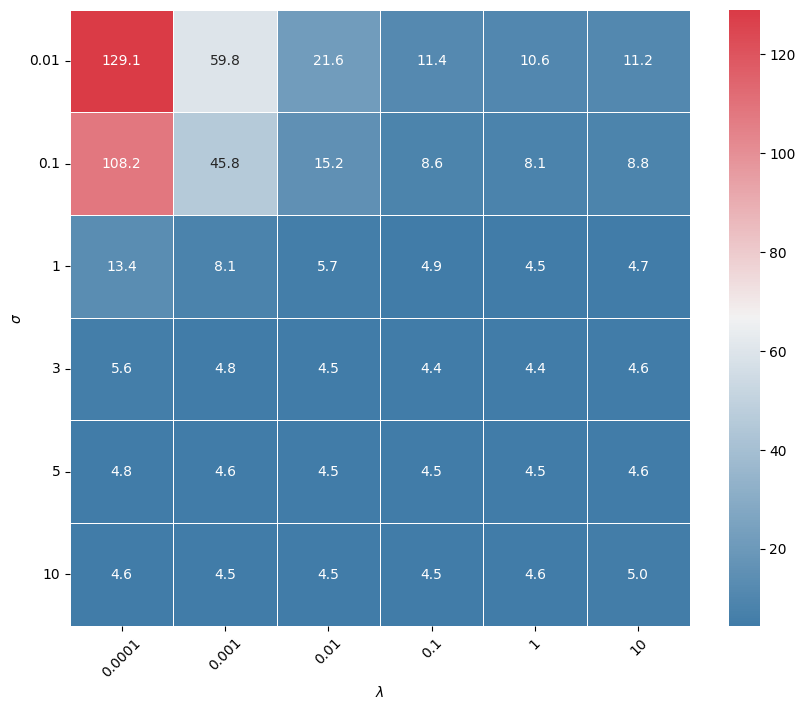

In [23]:
#visulization

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cmap_custom = sns.diverging_palette(240, 10, as_cmap=True)

plt.figure(figsize=(10, 8))
sns.heatmap(arr_rmse_oos*10000, cmap=cmap_custom, annot=True, fmt='.1f', linewidths=.5)

plt.xticks(np.arange(arr_rmse_oos.shape[1]) + 0.5, lst_l_in, rotation=45)
plt.xlabel('$\lambda$')

plt.yticks(np.arange(arr_rmse_oos.shape[0]) + 0.5, lst_sigma_in, rotation=0)
plt.ylabel('$\sigma$')

# plt.title('Cross-Validation Excess Return RMSE for $\lambda$ and \u03B1')
# plt.title('Cross-Validation Excess Return RMSE for $\lambda$ and $\sigma$')
plt.show()


# Load data

Price and cashflow data are contained in vector $B$ of dimension $M$ and matrix $C$ of dimension $M$-by-$N'$. $M$ is the number of securities in the cross-section. $N'$ is the maximum time-to-maturity in days of the data. For example, assume that there are three securities with prices 0.99, 0.98, and 0.97 maturing in 1, 3, and 5 days. Each of these securities has only one cash flow with value 1 due at maturity. Then, $B$ and $C$ take the following form:

$$B =
\begin{pmatrix}
0.99\\
0.98\\
0.97
\end{pmatrix}, 
$$

$$
C = 
\begin{pmatrix}
1 & 0 & 0 & 0& 0\\
0 & 0 & 1 & 0& 0\\
0 & 0 & 0 & 0& 1\\
\end{pmatrix}.
$$

In this example, $M=3$ and $N'=5$.

In the code block below, we load the data needed to estiamte returns on 1986-06-30 and 2013-12-31 relative to the next business day, 1986-07-01 and 2014-01-02. For each example date, we have:
- **date_s** is the number of days to the next business day
- **B** is the ex-dividend price vector
- **Bc_shift** is the shifted cum-dividend price vector
- **C** is the cashflow matrix
- **rf_t** is risk-free rate on example date t
- **g** is the daily discount curve

In [7]:
### load example data
dir_kr='./'
dir_data = dir_kr + 'example_data/'
example_dates=['1986-06-30', '2013-12-31']

with open(dir_data + 'dict_data.pkl','rb') as handle:
    dict_data = pickle.load(handle)
print(dict_data['1986-06-30'].keys())

dict_keys(['date_s', 'B', 'Bc_shift', 'C', 'rf_t', 'g'])


# Fit KR return model on example dates


In [10]:
### fit KR return model on example dates

l_fixed = 10.0 
R = 10
lst_R_fit = None

start_time = time.time()

dict_out = {}
for date in example_dates:
    
    B = dict_data[date]['B']
    Bc_shift = dict_data[date]['Bc_shift']
    C = dict_data[date]['C']
    date_s = dict_data[date]['date_s']
    nt=len(B)
    
    # normalize prices to 1
    Bc_shift = (1/B)*Bc_shift
    C = (1/B)[:,np.newaxis]*C
    B = np.ones(nt)*1
    
    # get return of securities
    rf = (1+dict_data[date]['rf_t'])**date_s-1 # scalar
    ret = (Bc_shift-B)/B
    rx = ret-rf
    
    Z_bar = C[:,date_s-1:]@np.diag(dict_data[date]['g'][date_s-1:N]) # dim: (nt, Nmax-date_s+1)
    Z = Z_bar[:,1:] # dim: (nt, Nmax-date_s)

    dict_full = models.one_fit(Z=Z,
                l_unscaled=l_fixed,
                rx=rx, # (Bc_shift-B)/B - rf
                date_s=date_s, # number of day shifts
                K=K # 2D, specific to alpha
                )

    # factor model
    dict_fm = models.FM_ridge_solution(Z=Z,
            l_unscaled=l_fixed,
            rx=rx, # (Bc_shift-B)/B - rf
            date_s=date_s, # number of day shifts
            V=dict_svd['V'], # svd of K
            D_diag=dict_svd['D_diag'], # svd of K
            R=R, # max number of factors
            lst_R_fit=lst_R_fit # list of r used for fitting. will override R above
            )
    
    dict_out[date] = {
                  'rx': rx, # rx of underlying securities
                  'ret':ret, # ret of underlying securities
                  'date_s':date_s, # date spacing
                  'rf':rf, # compounded rf with date_s
                  'dict_full':dict_full,
                  'dict_fm':dict_fm
                 }

end_time = time.time()

print('Time elapsed for fitting KR model for {} example dates: {:.1f} sec'\
      .format(len(example_dates),end_time-start_time))

Time elapsed for fitting KR model for 2 example dates: 9.8 sec


# Plot fitted curves

The code block below plots fitted excess returns up to the maximum time-to-maturity $N'$ in the data and the fitted excess return curve. 

3650
3650


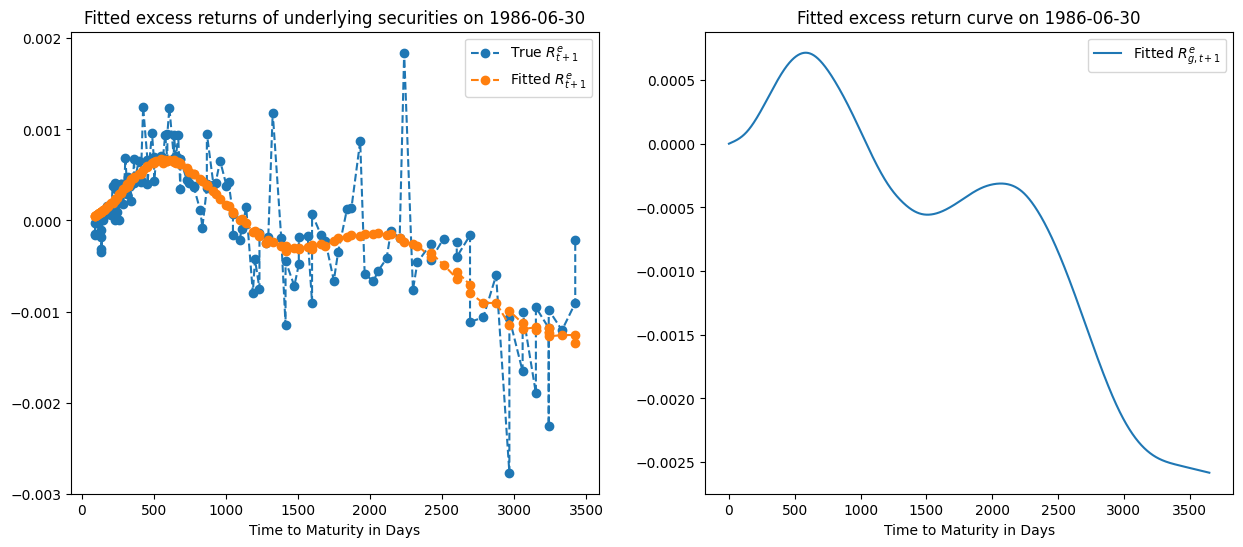

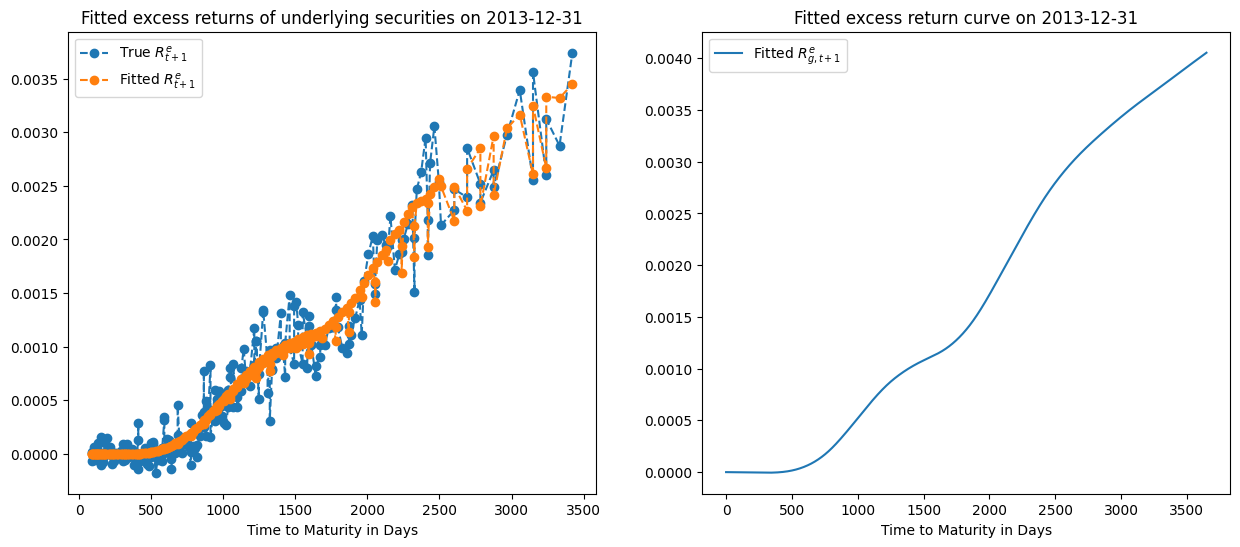

In [11]:
for date in example_dates:
    
    dict_t = dict_out[date]
    C = dict_data[date]['C']
    
    # get ttm in day for further analysis
    lst_ttm_inday = np.apply_along_axis(lambda row: len(row)-(row!=0)[::-1].argmax(),1,C)
    
    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
    
    rx_g_full=dict_t['dict_full']['rx_g_full']
    rx=dict_t['rx']
    rx_full=dict_t['dict_full']['rx_full']

    ax_1.plot(np.sort(lst_ttm_inday),rx[np.argsort(lst_ttm_inday)],'--o',label=r'True $R_{t+1}^e$')
    ax_1.plot(np.sort(lst_ttm_inday),rx_full[np.argsort(lst_ttm_inday)],'--o',label=r'Fitted $R_{t+1}^e$')
    ax_1.set_title('Fitted excess returns of underlying securities on {}'.format(date))
    
    ax_2.plot(rx_g_full,label=r'Fitted $R_{g,t+1}^e$')
    ax_2.set_title('Fitted excess return curve on {}'.format(date))

    for ax in [ax_1,ax_2]:
        ax.set_xlabel('Time to Maturity in Days')
        ax.legend();